<a href="https://colab.research.google.com/github/josethz00/dollar-forecast/blob/main/dollar_forecast_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Dependencies

In [3]:
!pip install fredapi && pip install prophet

## Imports and Config Variables

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime, timedelta
import requests
from prophet import Prophet
from fredapi import Fred
from prophet.make_holidays import make_holidays_df

# ====== CONFIG ======
FRED_API_KEY = os.getenv("FRED_API_KEY")

end_date = datetime.today()
start_date = end_date - timedelta(days=365 * 3)
start_str = start_date.strftime('%d/%m/%Y')
end_str = end_date.strftime('%d/%m/%Y')
start_iso = start_date.strftime('%Y-%m-%d')
end_iso = end_date.strftime('%Y-%m-%d')

url_usdbrl = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.1/dados?formato=json&dataInicial={start_str}&dataFinal={end_str}"
url_brazil_interest_rates = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.1178/dados?formato=json&dataInicial={start_str}&dataFinal={end_str}"

# COPOM is the committee that defines Brazil's interest rates
copom_meeting_dates = [
    # 2025
    "2025-06-18", "2025-05-07", "2025-03-19", "2025-01-29",
    # 2024
    "2024-12-11", "2024-11-06", "2024-09-18", "2024-07-31",
    "2024-06-19", "2024-05-08", "2024-03-20", "2024-01-31",
    # 2023
    "2023-12-13", "2023-11-01", "2023-09-20", "2023-08-02",
    "2023-06-21", "2023-05-03", "2023-03-22", "2023-02-01",
    # 2022
    "2022-12-07", "2022-10-26", "2022-09-21", "2022-08-03",
    "2022-06-15", "2022-05-04", "2022-03-16", "2022-02-02"
]
fed_meeting_dates = [
    # 2025
    "2025-12-17", "2025-11-05", "2025-09-17", "2025-07-30",
    "2025-06-18", "2025-05-07", "2025-03-19", "2025-01-29",
    # 2024
    "2024-12-11", "2024-11-06", "2024-09-18", "2024-07-31",
    "2024-06-12", "2024-05-01", "2024-03-20", "2024-01-31",
    # 2023
    "2023-12-13", "2023-11-01", "2023-09-20", "2023-07-26",
    "2023-06-14", "2023-05-03", "2023-03-22", "2023-02-01",
    # 2022
    "2022-12-14", "2022-11-02", "2022-09-21", "2022-07-27",
    "2022-06-15", "2022-05-04", "2022-03-16", "2022-01-26"
]
us_holidays = make_holidays_df(
    year_list=[2019 + i for i in range(10)], country='US'
)
br_holidays = make_holidays_df(
    year_list=[2019 + i for i in range(10)], country='BR'
)

## Fetching the historical data for USD-BRL

In [5]:
response = requests.get(url_usdbrl)
data_usdbrl = response.json()

df_usdbrl = pd.DataFrame(data_usdbrl)
df_usdbrl['ds'] = pd.to_datetime(df_usdbrl['data'], format='%d/%m/%Y')
df_usdbrl['y'] = df_usdbrl['valor'].astype(float)
df_usdbrl = df_usdbrl[['ds', 'y']]

## Adding regressors to enhance our model's performance

### Interest Rates

In [6]:
# ====== GETTING INTEREST RATES FROM BRAZIL ======
response = requests.get(url_brazil_interest_rates)
data_selic = response.json()

df_selic = pd.DataFrame(data_selic)
df_selic['ds'] = pd.to_datetime(df_selic['data'], format='%d/%m/%Y')
df_selic['selic'] = df_selic['valor'].astype(float)
df_selic = df_selic[['ds', 'selic']]

# Fill missing date if needed
today = pd.to_datetime(datetime.today().date())
if today not in df_selic['ds'].values:
    last_selic = df_selic.sort_values('ds')['selic'].iloc[-1]
    new_row = pd.DataFrame({'ds': [today], 'selic': [last_selic]})
    df_selic = pd.concat([df_selic, new_row], ignore_index=True)
    df_selic = df_selic.sort_values('ds').reset_index(drop=True)

# ====== GETTING INTEREST RATES FROM US ======
fred = Fred(api_key=FRED_API_KEY)
fedfunds = fred.get_series('FEDFUNDS', observation_start=start_iso, observation_end=end_iso)

df_fedfunds = fedfunds.reset_index()
df_fedfunds.columns = ['ds', 'fedfunds']
df_fedfunds['ds'] = pd.to_datetime(df_fedfunds['ds'])
df_fedfunds['fedfunds'] = df_fedfunds['fedfunds'].astype(float)
full_dates = pd.DataFrame({'ds': pd.date_range(start=df_fedfunds['ds'].min(), end=df_selic['ds'].max())})
df_fedfunds = full_dates.merge(df_fedfunds, on='ds', how='left')
df_fedfunds['fedfunds'] = df_fedfunds['fedfunds'].ffill()

# ====== MERGING IT ALL ======
df = df_usdbrl.merge(df_selic, on='ds', how='left')
df = df.merge(df_fedfunds, on='ds', how='left')

### Central Bank Meeting Dates

In [7]:
# ====== CREATE DATAFRAME WITH MEETINGS DATES ======
copom_df = pd.DataFrame(copom_meeting_dates, columns=["ds"])
copom_df["ds"] = pd.to_datetime(copom_df["ds"])
fed_df = pd.DataFrame(fed_meeting_dates, columns=["ds"])
fed_df['ds'] = pd.to_datetime(fed_df['ds'])

all_meetings_df = pd.concat([copom_df, fed_df]).drop_duplicates().sort_values("ds").reset_index(drop=True)

# ====== CATEGORIZE IF IT'S NEAR A CENTRAL BANK MEETING ======
def is_near_central_bank_meeting(date, days_before=5, days_after=1):
    date = pd.to_datetime(date)
    for meeting_date in all_meetings_df['ds']:
        if -days_before <= (date - meeting_date).days <= days_after:
            return 1
    return 0

df['near_cb_meeting'] = df['ds'].apply(is_near_central_bank_meeting)

## Setting up the Holidays

In [8]:
# Add a new column to distinguish between the two countries
us_holidays['country'] = 'US'
br_holidays['country'] = 'BR'

# Concatenate the two DataFrames into a single one
combined_holidays = pd.concat([us_holidays, br_holidays], ignore_index=True)

## Instantiate the model and plug the regressors

In [9]:
model_prophet = Prophet(
    changepoint_range=0.9,
    changepoint_prior_scale=0.1,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=combined_holidays
)
model_prophet.add_regressor('near_cb_meeting')
model_prophet.add_regressor('selic')
model_prophet.add_regressor('fedfunds')
model_prophet.fit(df)

# ====== FORECAST ======
future = model_prophet.make_future_dataframe(periods=45)
future['near_cb_meeting'] = future['ds'].apply(is_near_central_bank_meeting)

last_selic = df['selic'].ffill().iloc[-1]
last_fedfunds = df['fedfunds'].ffill().iloc[-1]
future = future.merge(df[['ds', 'selic', 'fedfunds']], on='ds', how='left')
future['selic'].fillna(last_selic, inplace=True)
future['fedfunds'].fillna(last_fedfunds, inplace=True)

forecast_prophet = model_prophet.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcewohna8/il01o9ll.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcewohna8/e25fr_zs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6294', 'data', 'file=/tmp/tmpcewohna8/il01o9ll.json', 'init=/tmp/tmpcewohna8/e25fr_zs.json', 'output', 'file=/tmp/tmpcewohna8/prophet_modelf73i3k1v/prophet_model-20250514225005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:50:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:50:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-9-dfe3cb593c92>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work be

## Plot forecasted values

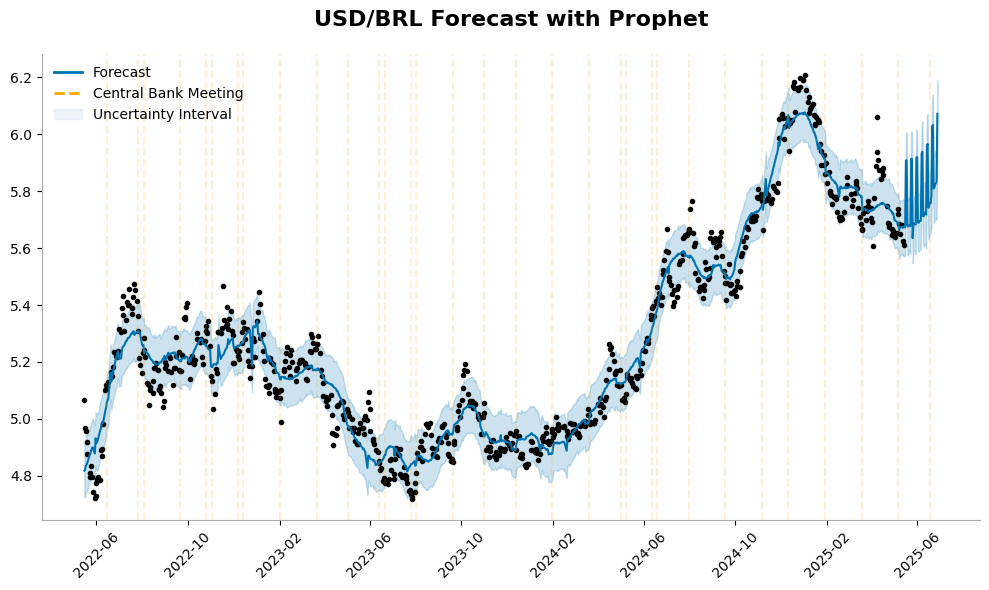

In [10]:
fig = model_prophet.plot(forecast_prophet)
ax = fig.gca()

ax.set_title('USD/BRL Forecast with Prophet', fontsize=16, fontweight='bold', pad=20)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#AAAAAA')
ax.spines['bottom'].set_color('#AAAAAA')
ax.grid(False)
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='both', labelsize=10)

for date in all_meetings_df['ds']:
    if df['ds'].min() <= date <= future['ds'].max():
        ax.axvline(date, color='orange', alpha=0.15, linestyle='--')

custom_lines = [
    plt.Line2D([0], [0], color='#0072B2', lw=2, label='Forecast'),
    plt.Line2D([0], [0], color='orange', lw=2, linestyle='--', label='Central Bank Meeting'),
    mpatches.Patch(color='#c6dbef', alpha=0.3, label='Uncertainty Interval')
]
ax.legend(handles=custom_lines, loc='upper left', frameon=False, fontsize=10)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
plt.tight_layout()
plt.show()

## Plot Trend

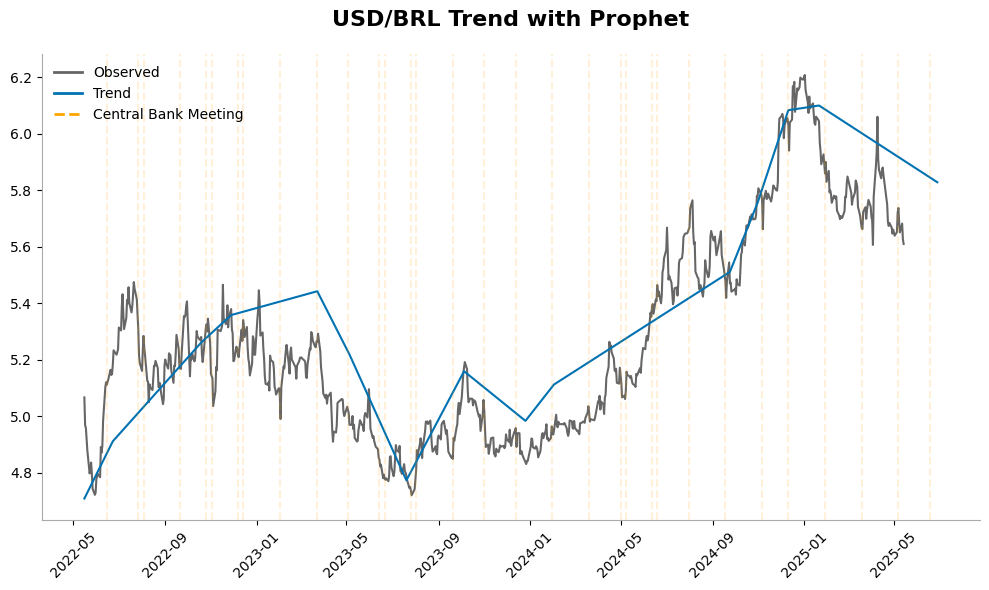

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df['ds'], df['y'], label='Observed', color='black', alpha=0.6)
ax.plot(forecast_prophet['ds'], forecast_prophet['trend'], label='Trend', color='#0072B2')

ax.set_title('USD/BRL Trend with Prophet', fontsize=16, fontweight='bold', pad=20)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#AAAAAA')
ax.spines['bottom'].set_color('#AAAAAA')

ax.grid(False)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='both', labelsize=10)

for date in all_meetings_df['ds']:
    if df['ds'].min() <= date <= future['ds'].max():
        ax.axvline(date, color='orange', alpha=0.15, linestyle='--')

custom_lines = [
    plt.Line2D([0], [0], color='black', alpha=0.6, lw=2, label='Observed'),
    plt.Line2D([0], [0], color='#0072B2', lw=2, label='Trend'),
    plt.Line2D([0], [0], color='orange', lw=2, linestyle='--', label='Central Bank Meeting')
]
ax.legend(handles=custom_lines, loc='upper left', frameon=False, fontsize=10)

fig.patch.set_facecolor('white')
ax.set_facecolor('white')

plt.tight_layout()
plt.show()

## Validating the Results

INFO:prophet:Making 22 forecasts with cutoffs between 2024-05-19 00:00:00 and 2025-03-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7873eff4ecd0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcewohna8/vq2bsfj_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcewohna8/eh9vxsnh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcewohna8/esnnyzkp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83300', 'data', 'file=/tmp/tmpcewohna8/vq2bsfj_.json', 'init=/tmp/tmpcewohna8/esnnyzkp.json', 'output', 'file=/tmp/tmpcewohna8/prophet_modelaa9b9jap/prophet_model-20250514230029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:00:29 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcewohna8/9y01f5e6.json
DEBUG:cmdstanpy:idx 0
INFO:cmdstanpy:Chain [

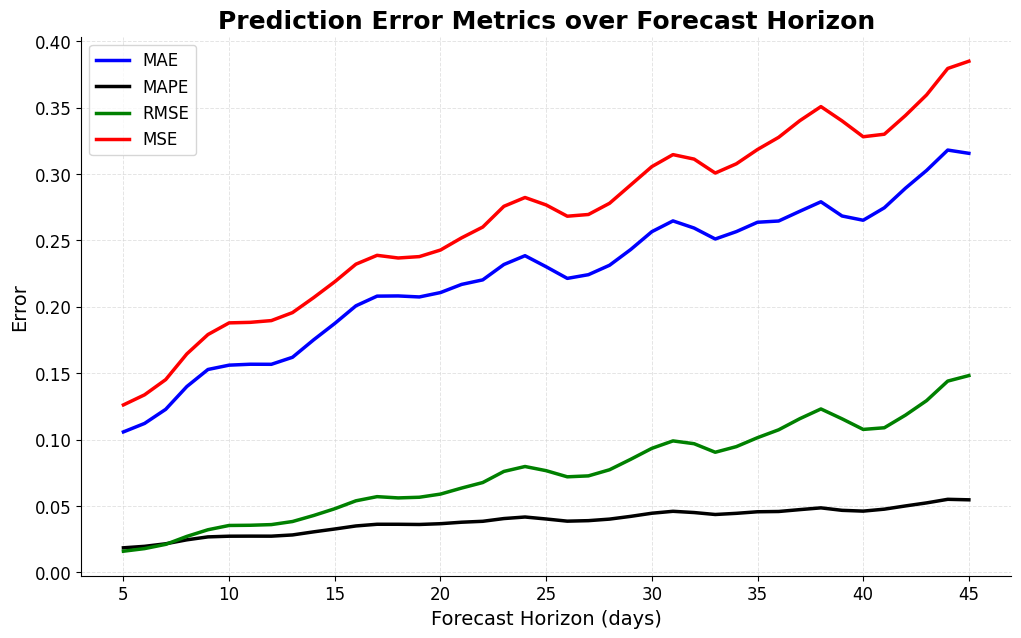

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt

df_cv = cross_validation(
    model_prophet,
    initial='730 days',  # 2 years for training
    period='15 days',    # New forecast every 15 days
    horizon='45 days',   # Forecast 45 days ahead
    parallel="processes"
)

df_p = performance_metrics(df_cv)
df_p['horizon_days'] = df_p['horizon'].dt.days
df_p = df_p.sort_values('horizon_days')


plt.figure(figsize=(12, 7))
# Plot MAE
plt.plot(df_p['horizon_days'], df_p['mae'], label='MAE', color='blue', linewidth=2.5)
# Plot MAPE
plt.plot(df_p['horizon_days'], df_p['mape'], label='MAPE', color='black', linewidth=2.5)
# Plot MSE
plt.plot(df_p['horizon_days'], df_p['mse'], label='RMSE', color='green', linewidth=2.5)
# Plot RMSE
plt.plot(df_p['horizon_days'], df_p['rmse'], label='MSE', color='red', linewidth=2.5)

plt.title('Prediction Error Metrics over Forecast Horizon', fontsize=18, fontweight='bold')
plt.xlabel('Forecast Horizon (days)', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.grid(color='lightgrey', linestyle='--', linewidth=0.7, alpha=0.6)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(fontsize=12)

plt.show()